# TPCNet: Target-Conditioned Triple-Path Consistency for Distributional Music Emotion Regression

Implementation of TPCNet with BiCAN front-end and TPC backbone for audio emotion recognition on S9k dataset.

**Note:** This notebook is a consolidated version of the original multi-file implementation for easier reproducibility. Due to stochastic factors in training, results from a single run are slightly different from those reported in the paper.

## 1. Environment Setup

In [1]:
import os
import random
import warnings
import json
import ast

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    hamming_loss, mean_squared_error, mean_absolute_error
)

import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.special import kl_div
from tqdm.notebook import tqdm
from tabulate import tabulate

warnings.filterwarnings('ignore')

def seed_everything(seed=42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 42
seed_everything(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Configuration

In [2]:
class Config:
    """Configuration following Section 4.4 of the paper."""

    # Data paths
    data_file = "../../dataset/songs_9822.csv"
    npz_file = "../../dataset/original_vggish.npz"
    output_dir = "./output/"

    # S9k Dataset: 12 emotion categories (Table 3)
    legal_emotions = [
        'Healing', 'Nostalgia', 'Excitement', 'Sadness', 'Romantic',
        'Quiet', 'Happiness', 'Loneliness', 'Touching', 'Missing',
        'Fresh', 'Relaxation'
    ]

    # Model (Table 4)
    E = 12  # Number of emotion categories
    hidden_size = 512

    # Training (Section 4.4)
    batch_size = 16
    num_train_epochs = 500  # Max epochs; early stopping typically stops earlier
    learning_rate = 1e-3    # Adam
    weight_decay = 1e-4
    lr_gamma = 0.95         # Exponential LR schedule
    patience = 5            # Early stopping (validation loss)


    # Data split (Section 4.5): 70/15/15
    sep_ratio = [0.3, 0.5]
    seed = 42

    # Runtime
    num_workers = 6
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

args = Config()
os.makedirs(args.output_dir, exist_ok=True)

print(f"Device: {args.device}")
print(f"Seed: {args.seed}")


Device: cuda
Seed: 42


## 3. Utility Functions

In [3]:
def seed_everything(seed=42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Determinism (may reduce speed on GPU)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)


def concordance_correlation_coefficient(y_true, y_pred):
    """Lin's CCC (Table 5)."""
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    covariance = np.cov(y_true, y_pred)[0, 1]
    return (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred) ** 2 + 1e-8)


def js_divergence(p, q, eps=1e-15):
    """Jensen–Shannon Divergence (Table 5)."""
    p_clip = np.clip(p, eps, 1.0)
    q_clip = np.clip(q, eps, 1.0)
    p_norm = p_clip / (p_clip.sum() + eps)
    q_norm = q_clip / (q_clip.sum() + eps)
    m = 0.5 * (p_norm + q_norm)
    return 0.5 * np.sum(p_norm * np.log(p_norm / m)) + 0.5 * np.sum(q_norm * np.log(q_norm / m))


seed_everything(args.seed)

## 4. Dataset & DataLoader

In [4]:
def pad_spectrogram(spectrogram, target_length):
    current_length = spectrogram.shape[-1]
    if current_length < target_length:
        padding = target_length - current_length
        spectrogram = F.pad(spectrogram, (0, padding), "constant", 0)
    return spectrogram


class AudioEmotionDataset(Dataset):
    """S9k Dataset (Table 3): 9822 tracks with soft distribution over 12 emotions"""
    
    def __init__(self, npz_file, df, transpose=True, target_width=469):
        self.df = df.drop_duplicates(subset='id').reset_index(drop=True)
        self.transpose = transpose
        self.target_width = target_width
        
        self.spectrograms = np.load(npz_file, mmap_mode='r')
        valid_ids = set(self.spectrograms.files)
        
        self.df['unique_id'] = self.df['id'].apply(lambda x: str(ast.literal_eval(x)[0]))
        self.df = self.df[self.df['unique_id'].isin(valid_ids)].reset_index(drop=True)
        
        self.labels = torch.tensor(self.df['label'].apply(eval).tolist(), dtype=torch.float)
        self.ratios = torch.tensor(self.df['ratio'].apply(eval).tolist(), dtype=torch.float)
        
        self.normalize = T.Normalize(mean=[0.5], std=[0.5])
        print(f"    Loaded {len(self.df)} samples")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        ratio = self.ratios[idx]
        
        unique_id = self.df.iloc[idx]['unique_id']
        spectrogram = self.spectrograms[unique_id]
        
        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-6)
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0)
        spectrogram = self.normalize(spectrogram)
        
        if self.transpose:
            spectrogram = spectrogram.transpose(1, 2)
        
        return {'audio': spectrogram, 'label': label, 'ratio': ratio}


def audio_collate_fn(batch_samples):
    target_length = max(sample['audio'].shape[-1] for sample in batch_samples)
    padded_spectrograms = [pad_spectrogram(sample['audio'], target_length) for sample in batch_samples]
    return {
        'spectrograms': torch.stack(padded_spectrograms),
        'true_labels': torch.stack([sample['label'] for sample in batch_samples]),
        'y': torch.stack([sample['ratio'] for sample in batch_samples])  # Ground-truth distribution y
    }


def create_dataloaders(args):
    """Create dataloaders with 70/15/15 split (Section 4.5)"""
    print("Loading S9k Dataset...")
    
    df = pd.read_csv(args.data_file)
    print(f"Total samples: {len(df)}")
    
    train_df, temp_df = train_test_split(df, test_size=args.sep_ratio[0], random_state=args.seed)
    val_df, test_df = train_test_split(temp_df, test_size=args.sep_ratio[1], random_state=args.seed)
    
    print(f"Train set (70%):")
    train_dataset = AudioEmotionDataset(args.npz_file, train_df)
    print(f"Validation set (15%):")
    val_dataset = AudioEmotionDataset(args.npz_file, val_df)
    print(f"Test set (15%):")
    test_dataset = AudioEmotionDataset(args.npz_file, test_df)
    
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, 
                              drop_last=True, collate_fn=audio_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, 
                            drop_last=True, collate_fn=audio_collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, 
                             drop_last=True, collate_fn=audio_collate_fn)
    
    return train_loader, val_loader, test_loader

In [5]:
train_loader, val_loader, test_loader = create_dataloaders(args)

sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Spectrograms: {sample_batch['spectrograms'].shape}")
print(f"  y (ground-truth distribution): {sample_batch['y'].shape}")

Loading S9k Dataset...
Total samples: 9822
Train set (70%):
    Loaded 6875 samples
Validation set (15%):
    Loaded 1473 samples
Test set (15%):
    Loaded 1474 samples

Sample batch:
  Spectrograms: torch.Size([16, 1, 128, 31])
  y (ground-truth distribution): torch.Size([16, 12])


## 5. TPCNet Model Architecture

Following Section 3 and Table 2:
- **BiCAN**: CNN-BiLSTM front-end with cross-attention (Eq. 1)
- **TPC Backbone**: Three coordinated paths
  - P-Path: Forward encoding of audio features
  - T-Path: Generative decoding from label intensities  
  - C-Path: Re-encoding of target anchors

In [6]:
class SAN(nn.Module):
    """Self-Attention Network for cross-attention fusion (Eq. 1)"""
    
    def __init__(self, d_model, nhead, dropout=0.1):
        super(SAN, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, query, key, value, src_mask=None, src_key_padding_mask=None):
        if query.dim() == 2:
            query = query.unsqueeze(0)
        if key.dim() == 2:
            key = key.unsqueeze(0)
        if value.dim() == 2:
            value = value.unsqueeze(0)
        
        if query.dim() == 4:
            batch_size, channels, height, width = query.shape
            query = query.permute(0, 2, 3, 1).reshape(-1, batch_size, channels)
            key = key.permute(0, 2, 3, 1).reshape(-1, batch_size, channels)
            value = value.permute(0, 2, 3, 1).reshape(-1, batch_size, channels)
        
        src2, _ = self.self_attn(query, key, value, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        src = query + self.dropout(src2)
        return self.norm(src)


class ResidualBlock(nn.Module):
    """Standard Residual block with pre-activation (recommended)"""
    
    def __init__(self, in_features, out_features, dropout=0.1):
        super(ResidualBlock, self).__init__()
        
        # Main path
        self.bn1 = nn.BatchNorm1d(in_features)
        self.activation1 = nn.Hardswish()
        self.linear1 = nn.Linear(in_features, out_features)
        
        self.bn2 = nn.BatchNorm1d(out_features)
        self.activation2 = nn.Hardswish()
        self.dropout = nn.Dropout(p=dropout)
        
        # Shortcut path
        self.shortcut = (
            nn.Linear(in_features, out_features)
            if in_features != out_features 
            else nn.Identity()
        )
    
    def forward(self, x):
        # Pre-activation residual block
        identity = self.shortcut(x)
        
        out = self.bn1(x)
        out = self.activation1(out)
        out = self.linear1(out)
        
        out = self.bn2(out)
        out = self.activation2(out)
        out = self.dropout(out)
        
        out = out + identity  
        return out


def triple_mse_loss(tensor1, tensor2, tensor3):
    """Triangular consistency loss (Eq. 8)"""
    loss12 = F.mse_loss(tensor1, tensor2)
    loss13 = F.mse_loss(tensor1, tensor3)
    loss23 = F.mse_loss(tensor2, tensor3)
    total_loss = (loss12 + loss13 + loss23) / 3
    return total_loss

In [7]:
class TPCNet(nn.Module):
    """
    TPCNet: BiCAN front-end + TPC backbone (Figure 1, Table 4)
    
    Following Table 2 notation:
    - p_d: P-Path features at depth d (prediction path)
    - t_d: T-Path features at depth d (target path)  
    - c_d: C-Path features at depth d (consistency path)
    - f_enc: Shared encoder (512 -> 256 -> 64 -> E)
    - f_dec: Dedicated decoder (1 -> 64 -> 256 -> 512)
    - f_head: Shared bottleneck head (E <-> 1)
    """
    
    def __init__(self, config):
        super(TPCNet, self).__init__()
        self.config = config  # store config for optional switches
        if not hasattr(self.config, 'use_triangular_L1'):
            self.config.use_triangular_L1 = True
        self.E = config.E  # Number of emotion categories
        
        # ============ BiCAN Front-end (Section 3.1) ============
        # CNN Branch: F_cnn
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout(0.3),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.Linear(128, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, config.E * 512), nn.ReLU(),
            nn.Unflatten(1, (config.E, 512))
        )
        
        # BiLSTM Branch: F_rnn
        self.rnn = self._build_rnn(config.E, 512)
        
        # Cross-Attention Fusion (Eq. 1)
        self.san = SAN(d_model=512, nhead=8, dropout=0.1)
        
        # ============ TPC Backbone (Section 3.2) ============
        # Shared Encoder f_enc: 512 -> 256 -> 64 -> E
        self.f_enc_512_256 = ResidualBlock(512, 256)
        self.f_enc_256_64 = ResidualBlock(256, 64)
        self.f_enc_64_1 = ResidualBlock(64, 1)
        
        # Dedicated Decoder f_dec: 1 -> 64 -> 256 -> 512
        self.f_dec_1_64 = ResidualBlock(1, 64)
        self.f_dec_64_256 = ResidualBlock(64, 256)
        self.f_dec_256_512 = ResidualBlock(256, 512)
        
        # Shared Bottleneck Head f_head: E <-> 1 (Eq. 5)
        self.f_head_E_1 = ResidualBlock(config.E, 1)
        self.f_head_1_E = ResidualBlock(1, config.E)
    
    def _build_rnn(self, E, hidden_size):
        """Build BiLSTM module"""
        class RNNModule(nn.Module):
            def __init__(self, E, hidden_size):
                super(RNNModule, self).__init__()
                self.E = E
                self.hidden_size = hidden_size
                self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size,
                                    num_layers=2, batch_first=True,
                                    bidirectional=True, dropout=0.3)
                self.fc = nn.Linear(hidden_size * 2, E * hidden_size)
                self.activation = nn.ReLU()

            def forward(self, x):
                lstm_out, _ = self.lstm(x)
                last_output = lstm_out[:, -1, :]
                fc_out = self.fc(last_output)
                activated = self.activation(fc_out)
                output = activated.view(x.size(0), self.E, self.hidden_size)
                return output

        return RNNModule(E, hidden_size)
    
    def forward(self, x, y):
        """
        Forward pass following Section 3.2-3.3
        
        Args:
            x: Input audio spectrogram
            y: Ground-truth distribution (B, E)
        
        Returns:
            total_loss, z (final prediction), pred_ratios
        """
        y = y.float()
        x = x.float()
        
        if x.dim() > 4:
            x = torch.squeeze(x)
        if x.dim() < 4:
            x = x.unsqueeze(1)
        
        # ========== BiCAN: Feature Extraction (Section 3.1, Eq. 1) ==========
        # F_cnn, F_rnn -> F_BiCAN
        F_cnn = self.cnn(x)
        
        if x.shape[-1] != 128:
            x_rnn = x.squeeze().permute(0, 2, 1)
        else:
            x_rnn = x.squeeze()
        F_rnn = self.rnn(x_rnn)
        
        # Bidirectional cross-attention fusion (Eq. 1)
        out1 = self.san(F_cnn, F_rnn, F_rnn)
        out2 = self.san(F_rnn, F_cnn, F_cnn)
        F_BiCAN = (out1 + out2) / 2  # F_BiCAN ∈ R^{B×E×512}
        
        B, E, _ = F_cnn.size()
        
        # ========== P-Path: Prediction Path (Eq. 2) ==========
        # p_512 -> p_256 -> p_64 -> p_E
        p_512 = F_BiCAN
        p_256 = self.f_enc_512_256(p_512.reshape(-1, 512))
        p_64 = self.f_enc_256_64(p_256)
        p_E = self.f_enc_64_1(p_64).squeeze().view(B, E)
        
        # Shared bottleneck head (Eq. 5): p_E -> p_1 -> p_E_rec
        p_1 = self.f_head_E_1(p_E)
        p_E_rec = self.f_head_1_E(p_1)
        
        # ========== T-Path: Target Path (Eq. 3) ==========
        # y_flat -> t_64 -> t_256 -> t_512
        t_E = y
        t_1 = self.f_head_E_1(y)
        t_E_rec = self.f_head_1_E(t_1)
        
        t_64 = self.f_dec_1_64(t_E.view(-1, 1))
        t_256 = self.f_dec_64_256(t_64)
        t_512 = self.f_dec_256_512(t_256).view(B, E, -1)
        
        # ========== C-Path: Consistency Path (Eq. 4) ==========
        # Residual fusion at each depth
        c_512 = t_512
        c_256 = (self.f_enc_512_256(c_512.view(-1, 512)) + t_256) / 2
        c_64 = (self.f_enc_256_64(t_256) + self.f_enc_256_64(c_256)) / 2
        c_E = (self.f_enc_64_1(t_64) + self.f_enc_64_1(c_64)) / 2
        c_E = c_E.squeeze().view(B, E)
        
        c_1 = self.f_head_E_1(c_E)
        c_E_rec = self.f_head_1_E(c_1)
        
        # ========== Loss Computation (Section 3.3) ==========
        # L_512: P-T alignment at depth 512
        L_512 = F.mse_loss(t_512, p_512)
        
        # L_tri at depths 256, 64, 1 (Eq. 8)
        L_256 = triple_mse_loss(c_256, p_256, t_256)
        L_64 = triple_mse_loss(c_64, p_64, t_64)
        L_1 = triple_mse_loss(p_1, c_1, t_1)

        # L_rec: Reconstruction at distribution level (Eq. 9)
        L_Ec = F.mse_loss(c_E_rec, y)
        L_Et = F.mse_loss(t_E_rec, y)
        L_rec = L_Ec + L_Et 
        
        # ========== Final Prediction (Eq. 6) ==========
        z = (p_E + p_E_rec) / 2
        pred_ratios = F.softmax(z, dim=1)
        
        # L_pred: KL divergence (Eq. 7)
        epsilon = 1e-10
        pred_log_probs = torch.log_softmax(z + epsilon, dim=-1)
        target_probs = (y + epsilon) / (y.sum(dim=1, keepdim=True) + epsilon)
        L_pred = F.kl_div(pred_log_probs, target_probs, reduction='batchmean')
        
        # Total loss (Eq. 10)
        total_loss = L_pred + L_512 + L_256 + L_64 + L_1 + L_rec
        
        loss_components = {
            'L_pred': L_pred.detach().item(),
            'L_512': L_512.detach().item(),
            'L_256': L_256.detach().item(),
            'L_64': L_64.detach().item(),
            'L_1': L_1.detach().item(),
            'L_Ec': L_Ec.detach().item(),
            'L_Et': L_Et.detach().item(),
            'total': total_loss.detach().item(),
        }

        return total_loss, z, pred_ratios, loss_components

In [8]:
# Create and verify model
model = TPCNet(args).to(args.device)

# Test forward pass
model.eval()
with torch.no_grad():
    spectrograms = sample_batch['spectrograms'].to(args.device)
    y = sample_batch['y'].to(args.device)
    loss, z, pred_ratios, _ = model(spectrograms, y)

print(f"\nForward pass: Input {spectrograms.shape} -> z {z.shape} -> distribution {pred_ratios.shape}")


Forward pass: Input torch.Size([16, 1, 128, 31]) -> z torch.Size([16, 12]) -> distribution torch.Size([16, 12])


## 6. Training

In [9]:
class LossRecorder:
    """Track total loss and the main TPC loss components."""

    def __init__(self, keys=None):
        self.epochs = []
        self.train_losses = []
        self.val_losses = []
        self.best_epoch = None

        self.keys = keys or []
        self.train_components = {k: [] for k in self.keys}
        self.val_components = {k: [] for k in self.keys}

    def record(self, epoch, train_loss, val_loss, train_comp=None, val_comp=None):
        self.epochs.append(epoch)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)

        if train_comp is not None:
            for k in self.keys:
                self.train_components[k].append(train_comp.get(k, np.nan))

        if val_comp is not None:
            for k in self.keys:
                self.val_components[k].append(val_comp.get(k, np.nan))


def train_model(args, train_loader, val_loader):
    """Train TPCNet following Section 4.4."""
    seed_everything(args.seed)

    model = TPCNet(args).to(args.device)
    optimizer = optim.AdamW(model.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.lr_gamma)

    loss_keys = ['L_pred', 'L_512', 'L_256', 'L_64', 'L_1', 'L_Ec', 'L_Et']
    loss_recorder = LossRecorder(keys=loss_keys)

    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_model_path = os.path.join(args.output_dir, 'TPCNet_best.pth')

    print(f"Training TPCNet (seed={args.seed})")

    for epoch in range(args.num_train_epochs):
        model.train()
        train_loss = 0.0
        train_comp_sum = {k: 0.0 for k in loss_keys}
        n_train_batches = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
        for batch in pbar:
            spectrograms = batch['spectrograms'].to(args.device)
            y = batch['y'].to(args.device)

            optimizer.zero_grad()
            loss, _, _, loss_comp = model(spectrograms, y)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            for k in loss_keys:
                train_comp_sum[k] += float(loss_comp.get(k, 0.0))
            n_train_batches += 1

            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        train_loss /= max(n_train_batches, 1)
        train_comp = {k: v / max(n_train_batches, 1) for k, v in train_comp_sum.items()}

        # Validation
        model.eval()
        val_loss = 0.0
        val_comp_sum = {k: 0.0 for k in loss_keys}
        n_val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                spectrograms = batch['spectrograms'].to(args.device)
                y = batch['y'].to(args.device)

                loss, _, _, loss_comp = model(spectrograms, y)
                val_loss += loss.item()
                for k in loss_keys:
                    val_comp_sum[k] += float(loss_comp.get(k, 0.0))
                n_val_batches += 1

        val_loss /= max(n_val_batches, 1)
        val_comp = {k: v / max(n_val_batches, 1) for k, v in val_comp_sum.items()}

        loss_recorder.record(epoch + 1, train_loss, val_loss, train_comp, val_comp)

        # Early stopping (patience=5)
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            patience_counter += 1
            if patience_counter >= args.patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: Train={train_loss:.4f}, Val={val_loss:.4f}")

    loss_recorder.best_epoch = best_epoch
    model.load_state_dict(torch.load(best_model_path, map_location=args.device))
    print(f"Best epoch: {best_epoch}, Val loss: {best_val_loss:.4f}")

    return model, loss_recorder


## 7. Evaluation Metrics (Section 4.2)

In [10]:
def _row_normalize(x, eps=1e-15):
    x = np.clip(x, eps, None)
    return x / (x.sum(axis=1, keepdims=True) + eps)


def calculate_regression_metrics(y_true, y_pred):
    """Distributional regression metrics (Table 5)."""
    eps = 1e-15
    y_true = _row_normalize(y_true, eps)
    y_pred = _row_normalize(y_pred, eps)

    n = len(y_true)
    mae = np.mean([mean_absolute_error(y_true[i], y_pred[i]) for i in range(n)])

    spearman_scores = [spearmanr(y_true[i], y_pred[i])[0] for i in range(n)]
    spearman = np.nanmean(spearman_scores)

    ccc = np.nanmean([concordance_correlation_coefficient(y_true[i], y_pred[i]) for i in range(n)])

    kld = np.mean([np.sum(kl_div(np.clip(y_true[i], eps, 1.0), np.clip(y_pred[i], eps, 1.0))) for i in range(n)])
    jsd = np.mean([js_divergence(y_true[i], y_pred[i], eps=eps) for i in range(n)])

    return {'MAE': mae, 'Spearman_ρ': spearman, 'CCC': ccc, 'KLD': kld, 'JSD': jsd}


def calculate_classification_metrics(true_labels, pred_labels):
    """Derived classification metrics (Table 5)."""
    per_class_f1 = [f1_score(true_labels[:, i], pred_labels[:, i], zero_division=0)
                    for i in range(true_labels.shape[1])]

    return {
        'mF1': f1_score(true_labels, pred_labels, average='micro', zero_division=0),
        'MF1': f1_score(true_labels, pred_labels, average='macro', zero_division=0),
        'HL': hamming_loss(true_labels, pred_labels),
        'per_class_F1': per_class_f1
    }


def get_predictions(model, data_loader, device):
    """Run inference and collect logits / distributions."""
    model.eval()
    all_z, all_pred_ratios = [], []
    all_true_labels, all_y = [], []

    with torch.no_grad():
        for batch in data_loader:
            spectrograms = batch['spectrograms'].to(device)
            y = batch['y'].to(device)
            true_labels = batch['true_labels'].to(device)

            _, z, pred_ratios, _ = model(spectrograms, y)

            all_z.append(z.cpu().numpy())
            all_pred_ratios.append(pred_ratios.cpu().numpy())
            all_true_labels.append(true_labels.cpu().numpy())
            all_y.append(y.cpu().numpy())

    z_np = np.concatenate(all_z, axis=0)
    pred_ratios_np = np.concatenate(all_pred_ratios, axis=0)
    true_labels_np = np.concatenate(all_true_labels, axis=0).astype(int)
    y_np = np.concatenate(all_y, axis=0)

    return {'z': z_np, 'pred_ratios': pred_ratios_np, 'y': y_np, 'true_labels': true_labels_np}


## 8. Run Experiment

In [11]:
# Train model
model, loss_recorder = train_model(args, train_loader, val_loader)

# Test predictions
test_pred = get_predictions(model, test_loader, args.device)

# Threshold: mean of test set z values (Section 4.2)
t_global = float(test_pred['z'].mean())

# Binarize predictions
test_binary = (test_pred['z'] > t_global).astype(int)
true_binary = test_pred['true_labels'].astype(int)

# Metrics (Table 5)
reg_metrics = calculate_regression_metrics(test_pred['y'], test_pred['pred_ratios'])
cls_metrics = calculate_classification_metrics(true_binary, test_binary)

predictions = {
    **test_pred,
    't_global': t_global,
    'pred_binary': test_binary,
    'true_binary': true_binary,
}

print("\nTest Results:")
print(f"  MAE={reg_metrics['MAE']:.3f}, ρ={reg_metrics['Spearman_ρ']:.3f}, CCC={reg_metrics['CCC']:.3f}")
print(f"  KLD={reg_metrics['KLD']:.3f}, JSD={reg_metrics['JSD']:.3f}")
print(f"  Threshold={t_global:.4f} -> mF1={cls_metrics['mF1']:.3f}, MF1={cls_metrics['MF1']:.3f}, HL={cls_metrics['HL']:.3f}")


Training TPCNet (seed=42)


Epoch 1:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 10: Train=0.8360, Val=0.8595


Epoch 11:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/429 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/429 [00:00<?, ?it/s]

Early stopping at epoch 18
Best epoch: 13, Val loss: 0.8369

Test Results:
  MAE=0.080, ρ=0.314, CCC=0.295
  KLD=0.760, JSD=0.211
  Threshold=-0.0634 -> mF1=0.610, MF1=0.608, HL=0.382


## 9. Results Summary

In [12]:
def print_results(reg_metrics, cls_metrics, emotions):
    """Print results in a Table 5-like layout."""
    print("\nDistributional Regression:")
    reg_headers = ['MAE↓', 'ρ↑', 'CCC↑', 'KLD↓', 'JSD↓']
    reg_values = [[
        f"{reg_metrics['MAE']:.3f}",
        f"{reg_metrics['Spearman_ρ']:.3f}",
        f"{reg_metrics['CCC']:.3f}",
        f"{reg_metrics['KLD']:.3f}",
        f"{reg_metrics['JSD']:.3f}"
    ]]
    print(tabulate(reg_values, headers=reg_headers, tablefmt='grid'))

    print("\nDerived Classification:")
    cls_headers = ['mF1↑', 'MF1↑', 'HL↓']
    cls_values = [[
        f"{cls_metrics['mF1']:.3f}",
        f"{cls_metrics['MF1']:.3f}",
        f"{cls_metrics['HL']:.3f}"
    ]]
    print(tabulate(cls_values, headers=cls_headers, tablefmt='grid'))

    print("\nPer-Class F1:")
    f1_values = [[f"{cls_metrics['per_class_F1'][i]:.3f}" for i in range(len(emotions))]]
    print(tabulate(f1_values, headers=emotions, tablefmt='grid'))

print_results(reg_metrics, cls_metrics, args.legal_emotions)



Distributional Regression:
+--------+-------+--------+--------+--------+
|   MAE↓ |    ρ↑ |   CCC↑ |   KLD↓ |   JSD↓ |
+========+=======+========+========+========+
|   0.08 | 0.314 |  0.295 |   0.76 |  0.211 |
+--------+-------+--------+--------+--------+

Derived Classification:
+--------+--------+-------+
|   mF1↑ |   MF1↑ |   HL↓ |
+========+========+=======+
|   0.61 |  0.608 | 0.382 |
+--------+--------+-------+

Per-Class F1:
+-----------+-------------+--------------+-----------+------------+---------+-------------+--------------+------------+-----------+---------+--------------+
|   Healing |   Nostalgia |   Excitement |   Sadness |   Romantic |   Quiet |   Happiness |   Loneliness |   Touching |   Missing |   Fresh |   Relaxation |
+===========+=============+==============+===========+============+=========+=============+==============+============+===========+=========+==============+
|     0.645 |       0.621 |        0.722 |     0.638 |      0.604 |    0.55 |       0.613 |

## 10. Visualization

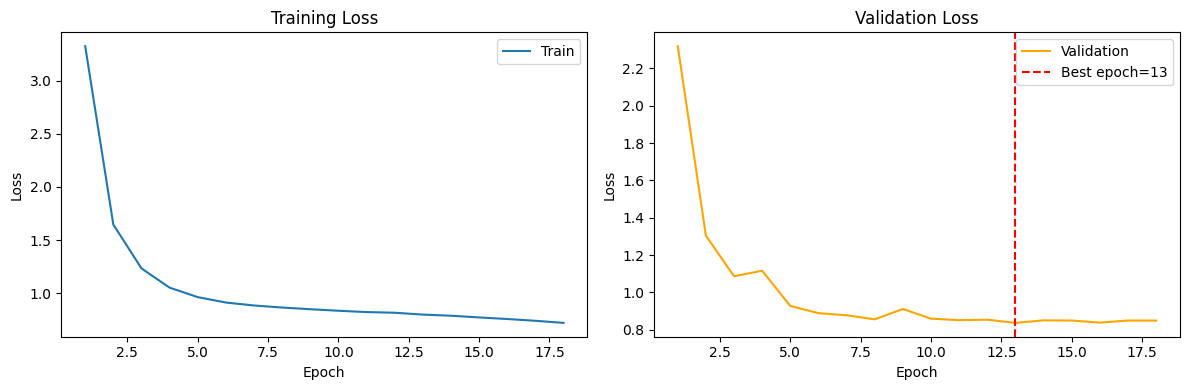

In [13]:
def plot_training_curves(loss_recorder):
    """Plot training curves (Figure 4 style)"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(loss_recorder.epochs, loss_recorder.train_losses, label='Train')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss')
    axes[0].legend()
    
    axes[1].plot(loss_recorder.epochs, loss_recorder.val_losses, label='Validation', color='orange')
    if loss_recorder.best_epoch:
        axes[1].axvline(x=loss_recorder.best_epoch, color='red', linestyle='--', label=f'Best epoch={loss_recorder.best_epoch}')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Validation Loss')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(args.output_dir, 'training_curves.png'), dpi=150)
    plt.show()

plot_training_curves(loss_recorder)

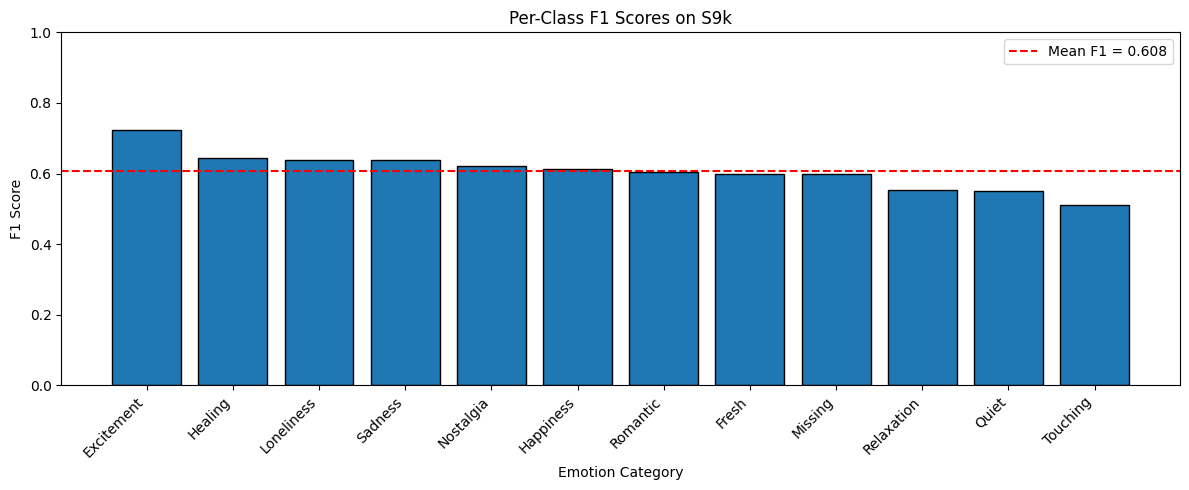

In [14]:
def plot_per_class_f1(per_class_f1, emotions, filename="per_class_f1.png"):
    """Plot per-class F1 scores."""
    fig, ax = plt.subplots(figsize=(12, 5))

    x = np.arange(len(emotions))
    sorted_indices = np.argsort(per_class_f1)[::-1]
    sorted_emotions = [emotions[i] for i in sorted_indices]
    sorted_f1 = [per_class_f1[i] for i in sorted_indices]

    ax.bar(x, sorted_f1, edgecolor='black')

    mean_f1 = np.mean(per_class_f1)
    ax.axhline(y=mean_f1, color='red', linestyle='--', label=f'Mean F1 = {mean_f1:.3f}')

    ax.set_xlabel('Emotion Category')
    ax.set_ylabel('F1 Score')
    ax.set_title('Per-Class F1 Scores on S9k')
    ax.set_xticks(x)
    ax.set_xticklabels(sorted_emotions, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.savefig(os.path.join(args.output_dir, filename), dpi=150)
    plt.show()

plot_per_class_f1(cls_metrics['per_class_F1'], args.legal_emotions)
